# Desarrollo Prueba Técnica - Cristóbal Domínguez

In [519]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Se lee el archivo con los pulsos

In [520]:
df = pd.read_csv('vehicle_gps.csv')
df["timestamp"]=pd.to_datetime(df.timestamp) # se convierten las fechas a un formato de fecha manejable


In [521]:
#Se construye una bounding box para la impresíon de los datos en un mapa

BBox = ((df.longitude.min(),   df.longitude.max(),      
         df.latitude.min(), df.latitude.max()))






In [522]:
# Se carga una imagen correspondiente al mapa de las locaciones

santiago_map = plt.imread('map2.png')

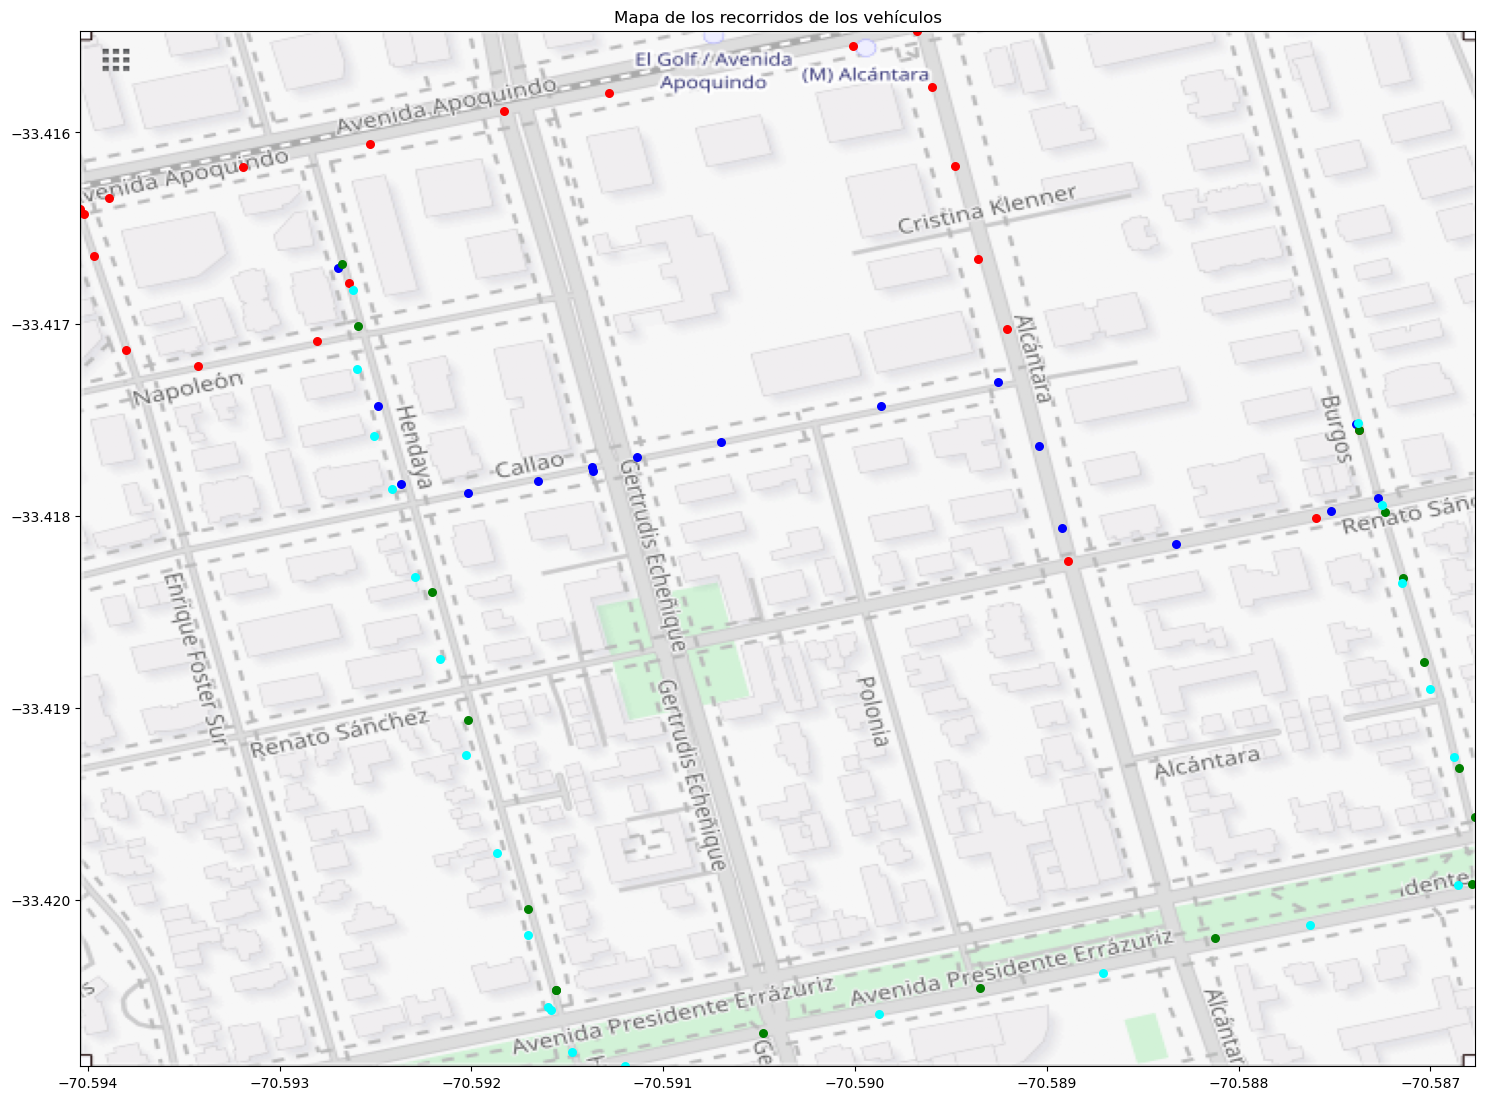

In [523]:
# se imprime un mapa con los recorridos 

fig, ax = plt.subplots(figsize = (18,17))
ax.scatter(df.longitude[df.vehicle == 'A'], df.latitude[df.vehicle == 'A'], zorder=1, alpha= 1, c='b', s=30)
ax.scatter(df.longitude[df.vehicle == 'B'], df.latitude[df.vehicle == 'B'], zorder=1, alpha= 1, c='r', s=30)
ax.scatter(df.longitude[df.vehicle == 'C'], df.latitude[df.vehicle == 'C'], zorder=1, alpha= 1, c='g', s=30)
ax.scatter(df.longitude[df.vehicle == 'D'], df.latitude[df.vehicle == 'D'], zorder=1, alpha= 1, c='cyan', s=30)
ax.set_title('Mapa de los recorridos de los vehículos')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(santiago_map, zorder=0, extent = BBox, aspect= 'equal')

Se observa que las rutas tienen un inicio y final en las mismas locaciones, respectivamente (calle Hendaya y calle Burgos)

In [524]:
from math import radians, cos, sin, asin, sqrt, isnan, pi
#Función para las distancias geográficas. (Haversine formula)

def distance(p1_lat, p1_lon, p2_lat, p2_lon):
    lon1 = radians(p1_lon)
    lon2 = radians(p2_lon)
    lat1 = radians(p1_lat)
    lat2 = radians(p2_lat)
      
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))   
   
    r = 6371 #radio de la tierra aproximado
      

    return(c * r)


In [525]:
#Se define una distancia de tolerancia para la agrupación de puntos

r=6371

m_distance=17 #metros

m_latitude_arc=m_distance*360/(r*1000*2*pi)

#agrupa los puntos por latitud, en primer lugar dado que la longitud de un arco de latitud no depende de la longitud 
df["group_diff"] = df.sort_values("latitude")["latitude"]\
                     .diff()\
                     .gt(m_latitude_arc)\
                     .cumsum()
# se agregan dos columnas para comparar las posiciones de cada punto con el anterior

df[["latitude2","longitude2"]]=df.sort_values(["group_diff","longitude"])[["latitude","longitude"]].shift()

#funcion lambda para la medicion de distancia geografica entre puntos

dist_func=lambda row: distance(row["latitude"],row["longitude"],row["latitude2"],row["longitude2"])

# se aplica la funcion para la medicion de distancia geografica

df["dist"]=df.sort_values(by=['group_diff','latitude']).apply(dist_func,axis=1)

# se agrupa por distancias entre puntos despues de haber agrupado por latitud    
    
df["grouped"] = df.sort_values(["group_diff","longitude"])["dist"]\
                     .gt(m_distance/1000)\
                     .cumsum()

# se eliminan las columnas sobrantes

df = df.drop(["latitude2","longitude2","group_diff","dist"],axis=1)

df.sort_values(by=['grouped'])



vehicle   latitude  longitude           timestamp  grouped
65       D -33.420575 -70.591587 2022-01-01 08:14:00        0
64       D -33.420560 -70.591598 2022-01-01 08:13:00        0
44       C -33.420470 -70.591560 2022-01-01 08:05:00        0
43       C -33.420470 -70.591560 2022-01-01 08:04:00        0
66       D -33.420797 -70.591477 2022-01-01 08:16:00        1
..     ...        ...        ...                 ...      ...
27       B -33.415890 -70.591830 2022-01-01 08:09:00       50
28       B -33.415794 -70.591285 2022-01-01 08:11:00       51
31       B -33.415762 -70.589598 2022-01-01 08:13:00       52
29       B -33.415549 -70.590009 2022-01-01 08:12:00       53
30       B -33.415469 -70.589676 2022-01-01 08:12:00       54

[77 rows x 5 columns]

A continuación se muestran los grupos de puntos de acuerdo a su proximidad:

In [534]:
grouped = df.groupby(["grouped"])
grouped.groups


{0: [43, 44, 64, 65], 1: [66], 2: [67], 3: [45], 4: [68], 5: [46], 6: [69], 7: [42, 63], 8: [47], 9: [70], 10: [48, 71], 11: [62], 12: [49], 13: [61], 14: [50, 72], 15: [41], 16: [60], 17: [51, 73], 18: [20], 19: [19], 20: [18], 21: [56], 22: [39], 23: [57], 24: [1], 25: [2, 58], 26: [40, 59], 27: [3], 28: [4], 29: [5, 6], 30: [7], 31: [8], 32: [9], 33: [10], 34: [34], 35: [11], 36: [12], 37: [35], 38: [13], 39: [14, 36], 40: [16, 37, 54, 76], 41: [15, 53, 75], 42: [52, 74], 43: [21], 44: [0, 17, 38, 55], 45: [33], 46: [22, 23, 24], 47: [25], 48: [26], 49: [32], 50: [27], 51: [28], 52: [31], 53: [29], 54: [30]}

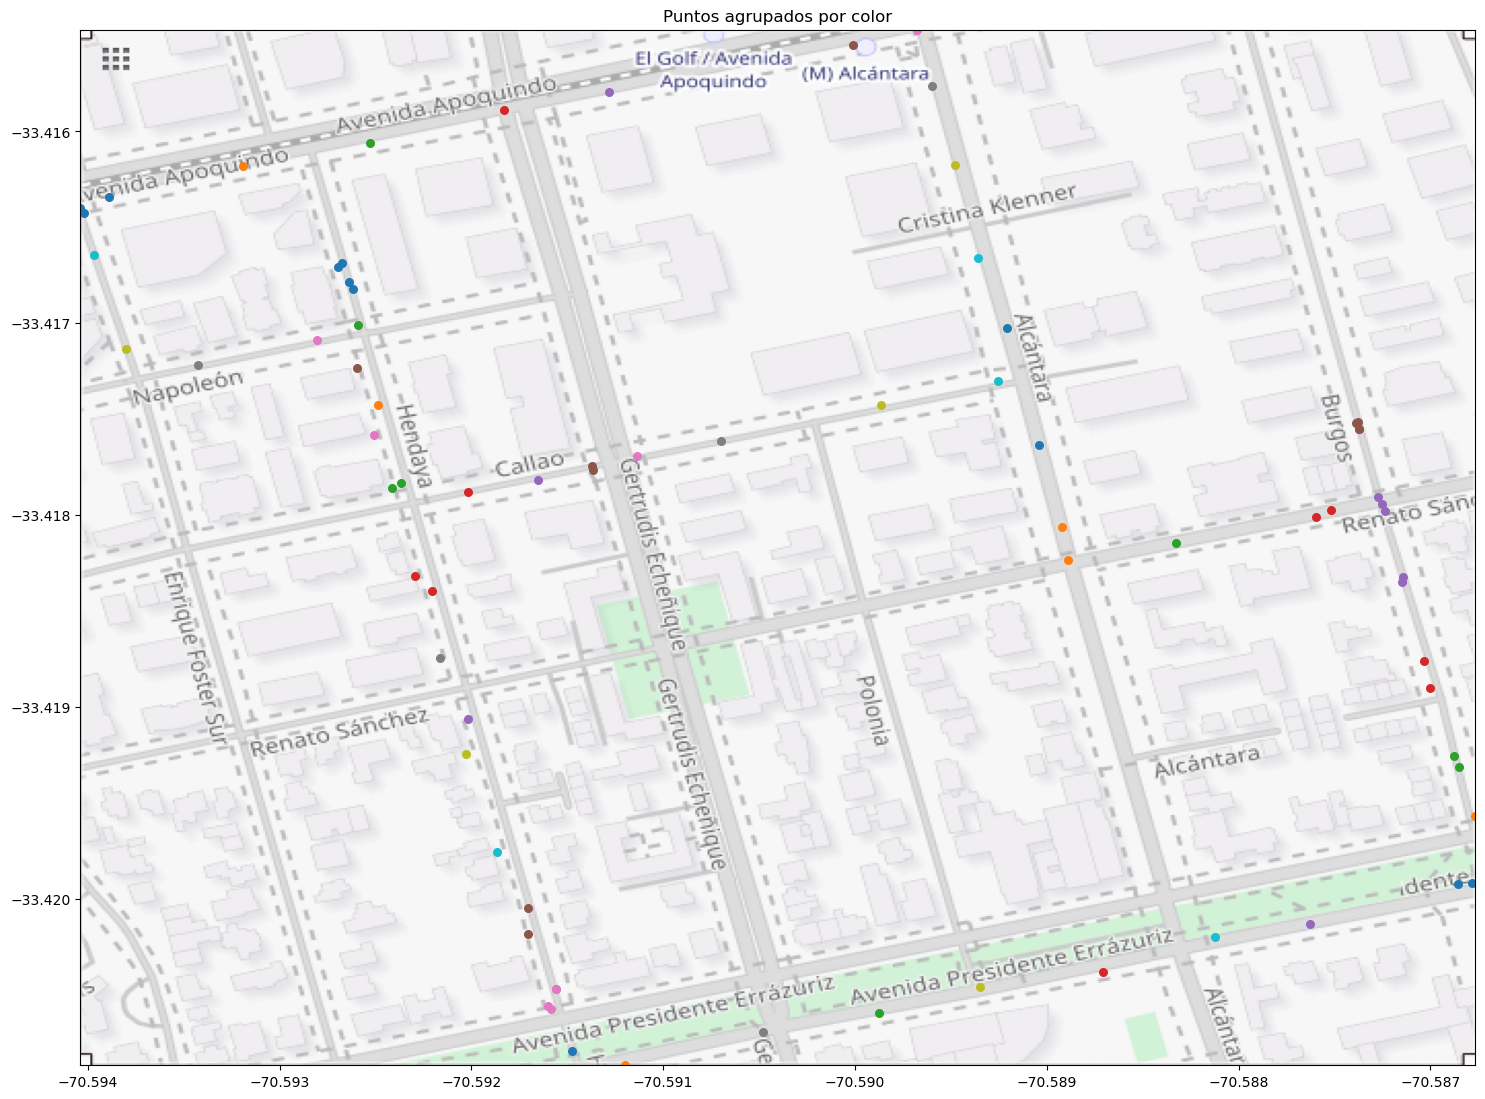

In [536]:

fig, ax = plt.subplots(figsize = (18,17))
for g in df.grouped.unique():
    ax.scatter(df.longitude[df.grouped == g], df.latitude[df.grouped == g], zorder=1, alpha= 1,  s=30)
ax.set_title('Puntos agrupados por color')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

Se calculan las aristas correspondientes a los recorridos de los vehiculos entre cada punto


In [537]:
# se calcula el tiempo entre puntos

df["diff_time"]=(df.groupby(['vehicle'])['timestamp'].diff()).dt.total_seconds()/60


# se computan las aristas correspondientes a los recorridos de los vehiculos entre cada punto

last_index=0

edges=[]

for index, row in df[1:].iterrows():    
    if not isnan(row.diff_time):    
        edges.append((last_index,index,row.diff_time)) # (nodo 1, nodo 2, peso(tiempod e recorrido))    
    last_index=index

    
    

Se calculan los nodos del grafo para luego unirlos con las aristas obtenidas anteriormente




In [ ]:
grouped_nodes=grouped.groups # grupos de puntos para la generacion de nodos
inverted_nodes = {} # referencia desde los puntos del mapa hacia los nodos creados

for k,v in grouped_nodes.items():
    for n in v:      
        inverted_nodes[n]=k
        
# aristas del grafo con sus correspondientes pesos (tiempo de recorrido)
        
new_edges=[(inverted_nodes[e[0]],inverted_nodes[e[1]],e[2]) for e in edges if inverted_nodes[e[0]] != inverted_nodes[e[1]]]        

# se inicializa el grafo

G = nx.Graph()

# dataframe con las latitudes y longitudes de cada nodo, para obtener el centroide 

df2 = df.groupby("grouped")[['latitude','longitude']].mean()

# se genera lista con la informcaion de los nodos incluido el centroide 

nodes = [(r[0],{"latitude":r[1],"longitude":r[2]}) for r in df2.itertuples(index=True,name=None)]

# se añaden los nodes al grafo

G.add_nodes_from(nodes)

# se añaden las aristas al grafo, con los pesos correspondientes

G.add_weighted_edges_from(new_edges)

### Vista del grafo 

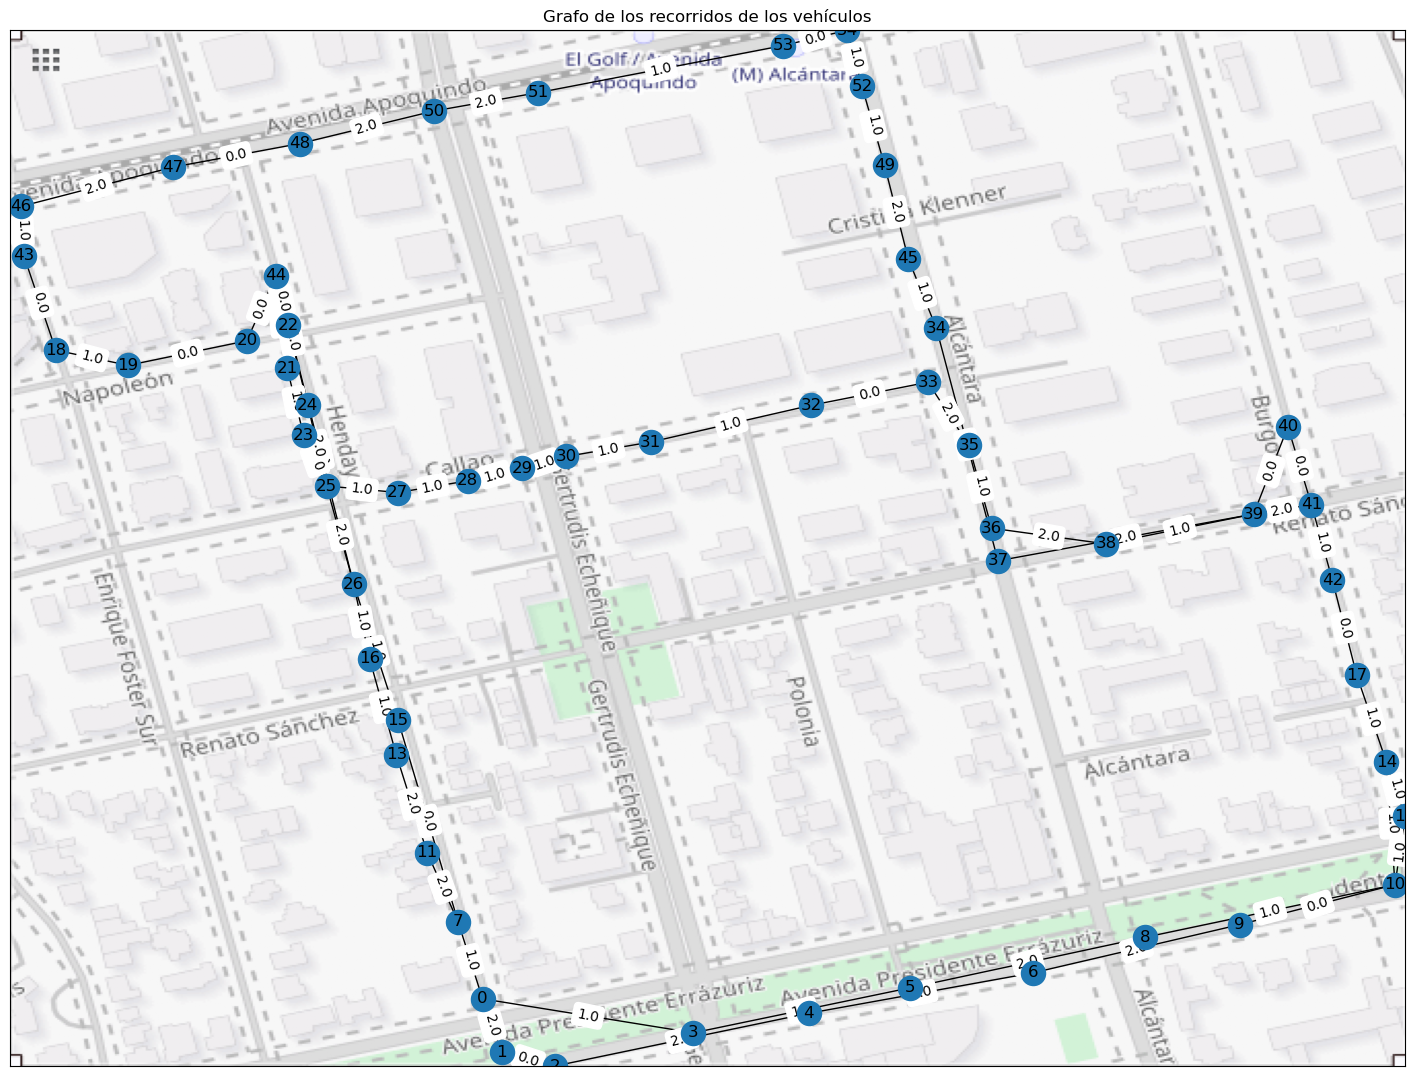

In [547]:
pos={k: (v["longitude"],v["latitude"]) for k,v in G.nodes(data=True, default=1)}
fig, ax = plt.subplots(figsize = (18,17))

ax.set_title('Grafo de los recorridos de los vehículos')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
nx.draw_networkx(G,pos=pos, with_labels = True)
nx.draw_networkx_edge_labels(G,pos=pos,edge_labels=labels)
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

### Obtención del camino más corto

Para obtener el camino más corto entre cualquiera de los nodos, se puede aplicar el algoritmo de Dijkstra. Dado que el grafo no es dirigido, ya que se asumió el recorrido bidireccional, además de ser conexo, permite el cálculo del camino, mas corto entre cualquier par de nodos.

Para esto se procede a utilizar la función de shortest_path de Networkx, que utiliza normalmente el algoritmo de Dijkstra.


In [558]:
# obtencion del camino mas corto entre los nodos 0 y 50

sp=nx.shortest_path(G, source=0, target=50,weight='weight')
elapsed_time=nx.path_weight(G, sp, weight='weight')

print(sp, elapsed_time)



[0, 7, 15, 26, 22, 44, 20, 19, 18, 43, 46, 47, 48, 50] 9.0


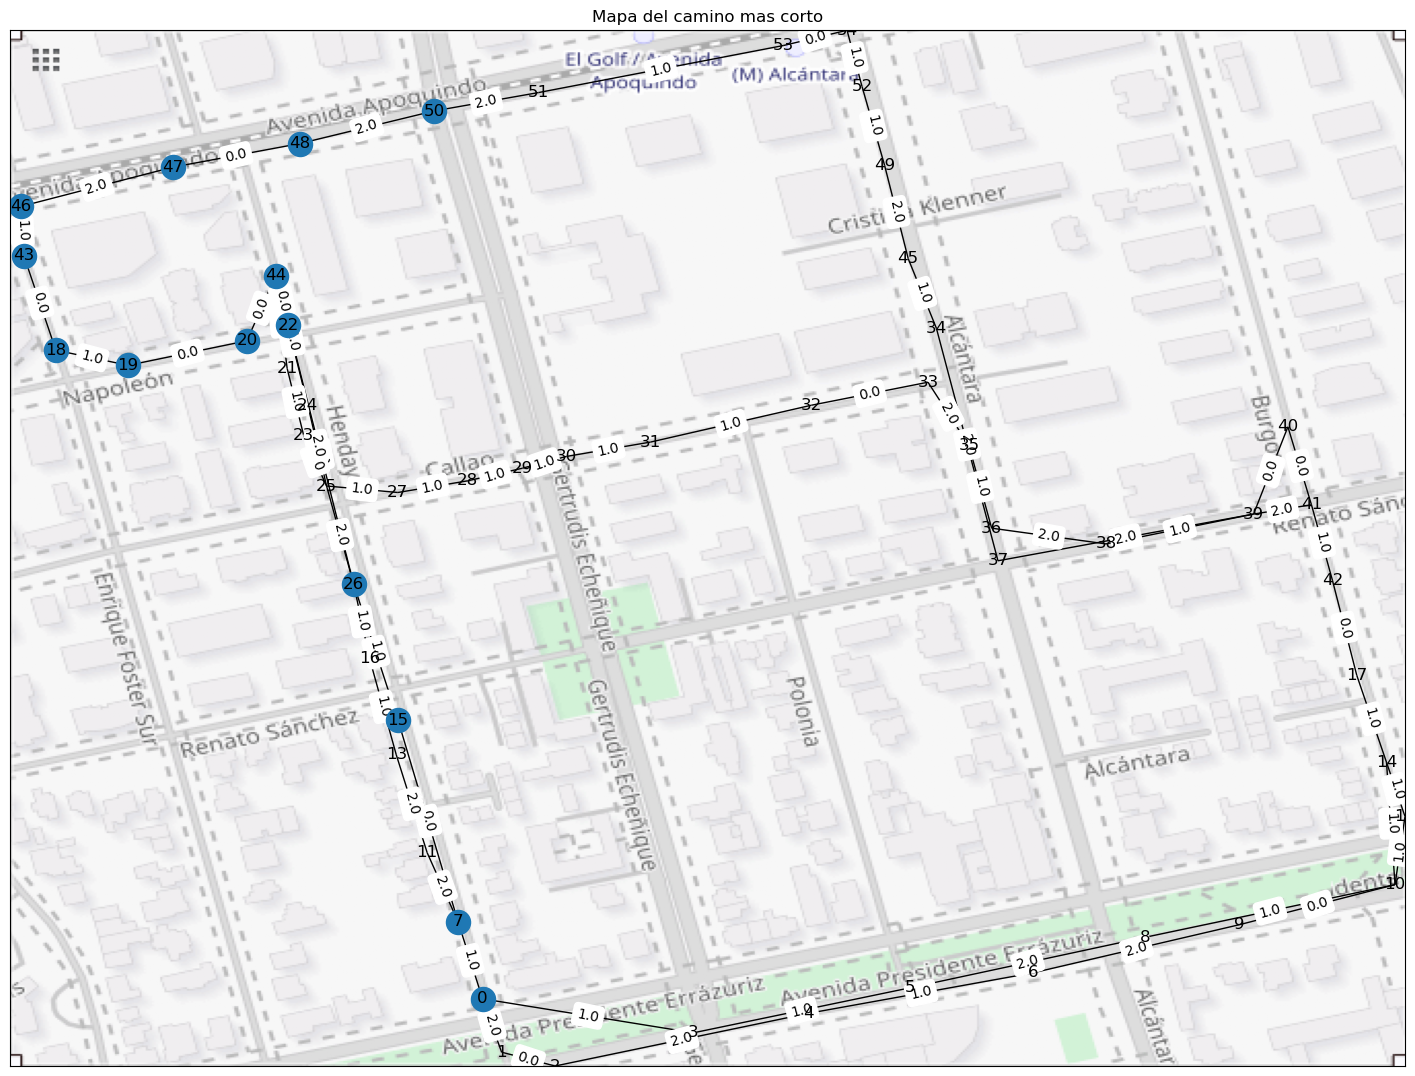

In [559]:

# se dibujan los nodos recorridos

fig, ax = plt.subplots(figsize = (18,17))

ax.set_title('Mapa del camino mas corto')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx(G,pos=pos,nodelist=sp)
nx.draw_networkx_edge_labels(G,pos=pos,edge_labels=labels)
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

Por último se obtiene la función para calcular el camino más corto:

In [560]:
def get_shortest_path(node1,node2):
    """Obtiene el camino más corto

    Parameters:
    node1: nombre del nodo 1
    node2: nombre del nodo 2
    
    Returns:
    list: lista de los nodos recorridos
    float: tiempo tomado en el recorrido
    """
    sp=nx.shortest_path(G, source=node1, target=node2, weight='weight')
    elapsed_time=nx.path_weight(G, sp, weight='weight')
    return sp, elapsed_time

print(get_shortest_path(0,1))
    

([0, 1], 2.0)
